In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg

In [6]:
def fitEllipsoid(magX, magY, magZ):
    a1 = magX ** 2
    a2 = magY ** 2
    a3 = magZ ** 2
    a4 = 2 * np.multiply(magY, magZ)
    a5 = 2 * np.multiply(magX, magZ)
    a6 = 2 * np.multiply(magX, magY)
    a7 = 2 * magX
    a8 = 2 * magY
    a9 = 2 * magZ
    a10 = np.ones(len(magX)).T
    # D = np.array([a1, a2, a3, a4, a5, a6, a7, a8, a9, a10])
    D = np.array([a1, a2, a3, a4, a5, a6, a7, a8, a9, a10])

    # print(D)
    # print(a1.shape)
    # print(a2.shape)
    # print(a3.shape)
    # print(a4.shape)
    # print(a5.shape)
    # print(a6.shape)
    # print(a7.shape)
    # print(a8.shape)
    # print(a9.shape)
    # print(a10.shape)
    # print(D.ndim)
    #print(D.shape)
    #print(D.T.shape)
    # print(D.shape[0])
    # print(D.shape[1])

    # # Eqn 7, k = 4
    C1 = np.array([[-1, 1, 1, 0, 0, 0],
                   [1, -1, 1, 0, 0, 0],
                   [1, 1, -1, 0, 0, 0],
                   [0, 0, 0, -4, 0, 0],
                   [0, 0, 0, 0, -4, 0],
                   [0, 0, 0, 0, 0, -4]])

    # # Eqn 11
    S = np.matmul(D, D.T)
    # print(S)
    # print("-----------------")
    S11 = S[:6, :6]
    # print(S11)
    S12 = S[:6, 6:]
    S21 = S[6:, :6]
    S22 = S[6:, 6:]

    # Eqn 15, find eigenvalue and vector
    # Since S is symmetric, S12.T = S21
    tmp = np.matmul(np.linalg.inv(C1), S11 - np.matmul(S12, np.matmul(np.linalg.inv(S22), S21)))
    eigenValue, eigenVector = np.linalg.eig(tmp)
    #print(eigenVector)
    #print(eigenValue)
    #print(max(eigenValue))
    u1 = eigenVector[:, np.argmax(eigenValue)]
    #print(np.argmax(eigenValue))
    #print(u1)
    #print(u1.shape)

    #print(np.linalg.inv(C1))

    # # Eqn 13 solution
    u2 = np.matmul(-np.matmul(np.linalg.inv(S22), S21), u1)
    # tmp = (-np.matmul(np.linalg.inv(S22), S21))
    # print(tmp.shape)
    #print(u2)

    # # Total solution
    u = np.concatenate([u1, u2]).T
    # print(u)
    # print(u.shape)

    Q = np.array([[u[0], u[5], u[4]],
                  [u[5], u[1], u[3]],
                  [u[4], u[3], u[2]]])

    n = np.array([[u[6]],
                  [u[7]],
                  [u[8]]])

    d = u[9]

    return Q, n, d

In [7]:
data = np.genfromtxt('magnetometer.csv', dtype=int, delimiter=',')
magX = data[:, 6] * 0.080
magY = data[:, 7] * 0.080
magZ = data[:, 8] * 0.080

In [ ]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.scatter(magX, magY, magZ, s=5, color='r')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# plot unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_wireframe(x, y, z, rstride=10, cstride=10, alpha=0.5)
ax1.plot_surface(x, y, z, alpha=0.3, color='b')

In [8]:
Q, n, d = fitEllipsoid(magX, magY, magZ)
#fitEllipsoid(magX, magY, magZ)

In [9]:
print(Q)
print ("-----------")
print(n)
print ("-----------")
print(d)

[[ 0.61687089 -0.06023708 -0.00091328]
 [-0.06023708  0.53223903  0.01015918]
 [-0.00091328  0.01015918  0.5765929 ]]
-----------
[[-47.33571242]
 [-15.96403898]
 [-61.23367615]]
-----------
-133523.57007006792


In [17]:
Qinv = np.linalg.inv(Q)
b = -np.dot(Qinv, n)
Ainv = np.real(1 / np.sqrt(np.dot(n.T, np.dot(Qinv, n)) - d) * linalg.sqrtm(Q))

tmp = np.real(1 / np.sqrt(np.dot(n.T, np.dot(Qinv, n)) - d))
print(tmp)

[[0.0026316]]


In [ ]:
print("Qinv: ")
print(Qinv)
print("A_inv: ")
print(Ainv)
print()
print("b")
print(b)
print()
print("Sqrt Q")
print(linalg.sqrtm(Q))

In [19]:
calibratedX = np.zeros(magX.shape)
calibratedY = np.zeros(magY.shape)
calibratedZ = np.zeros(magZ.shape)

print(calibratedX)

[0. 0. 0. ... 0. 0. 0.]


In [38]:

totalError = 0
for i in range(len(magX)):
    h = np.array([[magX[i], magY[i], magZ[i]]]).T
    hHat = np.matmul(Ainv, h-b)
    calibratedX[i] = hHat[0]
    calibratedY[i] = hHat[1]
    calibratedZ[i] = hHat[2]
    mag = np.dot(hHat.T, hHat)
    #print(mag[0][0]-1)
    err = (mag[0][0] -1)**2
    totalError += err
print("Total Error: %f" % totalError)

Total Error: 37.501352


In [31]:
print(h.shape)
print(hHat.T.shape)

(3, 1)
(1, 3)


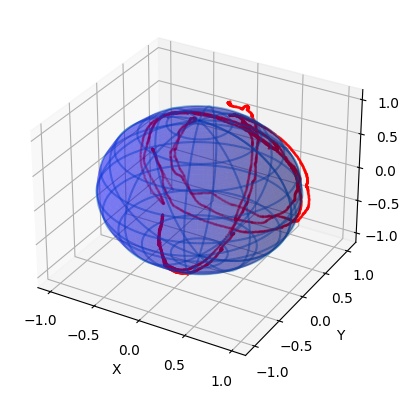

In [39]:
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111, projection='3d')

ax2.scatter(calibratedX, calibratedY, calibratedZ, s=1, color='r')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# plot unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax2.plot_wireframe(x, y, z, rstride=10, cstride=10, alpha=0.5)
ax2.plot_surface(x, y, z, alpha=0.3, color='b')
plt.show()


In [3]:
B = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                   [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                   [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
                   [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
                   [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
                   [61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
                   [71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
                   [81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
                   [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]])

In [4]:
S11 = B[:6, :6]
S12 = B[:6, 6:]
S21 = B[6:, :6]
S22 = B[6:, 6:]

In [13]:
print(S22)
#print(S22.shape)

[[ 67  68  69  70]
 [ 77  78  79  80]
 [ 87  88  89  90]
 [ 97  98  99 100]]
